In [46]:
import pandas as pd
import matplotlib.pyplot as plt

## 1. Training Progress

In [3]:
import os
import platform
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [6]:
model_out_dir = f"{DATA_PATH}/Models/e4e/00005_snapshot_1200"
log_path = f"{model_out_dir}/checkpoints/timestamp.txt"

In [43]:
with open(log_path, 'rb') as f:
    lines = f.readlines()
data = []
for i in range(0, len(lines), 2):
    if b'**Best**' in lines[i]:
        continue
    step_number = int(lines[i].decode().split('-')[1].strip().strip(','))
    values = ast.literal_eval(lines[i+1].decode().strip())
    values['Step'] = step_number
    data.append(values)

df = pd.DataFrame(data)
df.set_index('Step', inplace=True)
df = df[df.columns.drop(list(df.filter(regex='delta')))]
df.head(3)

,d_real_loss,d_fake_loss,discriminator_loss,discriminator_r1_loss,encoder_discriminator_loss,loss_id,id_improve,loss_l2,loss_lpips,loss
Step,,,,,,,,,,
0,0.706904,0.695301,1.402205,0.163341,0.695725,0.280144,-0.280144,0.198923,0.321401,0.665688
2000,0.211073,0.260886,0.471959,NaN,1.472274,0.123674,-0.123674,0.063341,0.175471,0.412782
4000,0.361316,0.375384,0.736700,NaN,1.165382,0.117885,-0.117885,0.056126,0.159958,0.359573


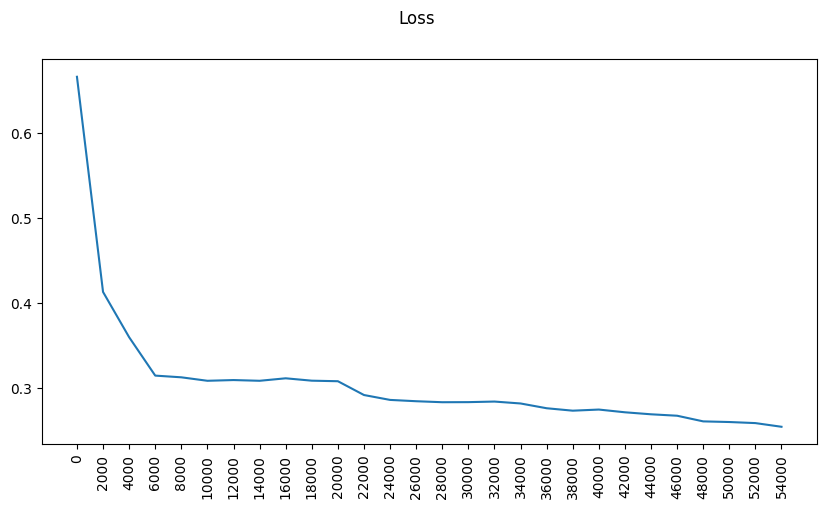

In [52]:
fig, ax = plt.subplots(figsize = (10,5))
plt.xticks(df.index)
ax.set_xticklabels(df.index, rotation=90)
plt.plot(df.loss)
fig.suptitle('Loss')
plt.show()

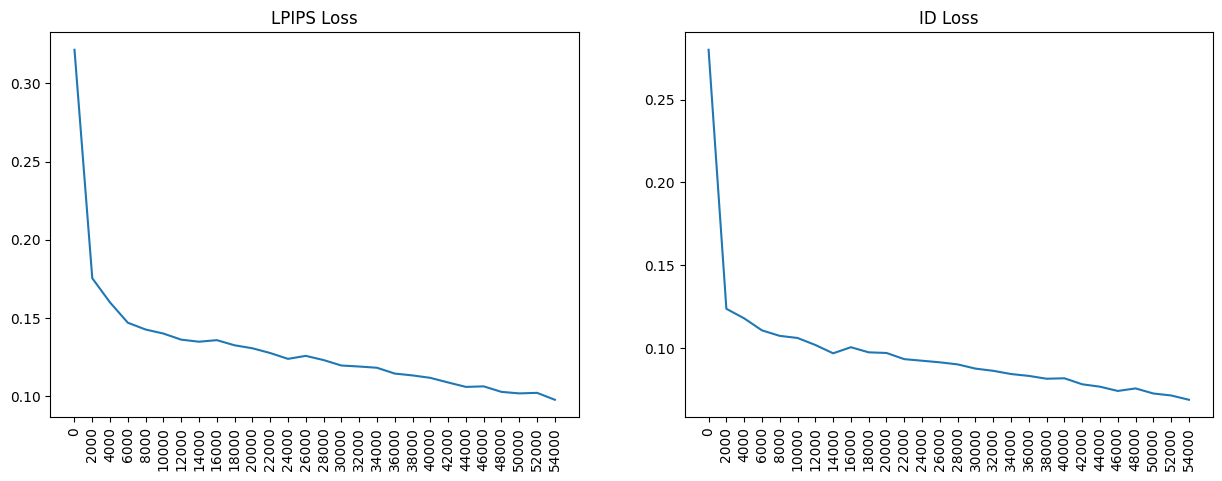

In [70]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(df.loss_lpips)
ax[0].set_title('LPIPS Loss')
ax[0].set_xticks(df.index)
ax[0].set_xticklabels(df.index, rotation=90)

ax[1].plot(df.loss_id)
ax[1].set_title('ID Loss')
ax[1].set_xticks(df.index)
ax[1].set_xticklabels(df.index, rotation=90)
plt.show()

## 2. Qualitative Evaluation

In [ ]:
from glob import glob
import os
os.chdir('../../encoder4editing/')

from scripts.inference import *

import matplotlib.pyplot as plt

In [2]:
# Setup Model
model_path = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/e4e/experiments_default_lr/checkpoints/best_model.pt"
device = 'cuda'

net, opts = setup_model(model_path, device)
generator = net.decoder
generator.eval()

# Get transforms
dataset_args = data_configs.DATASETS[opts.dataset_type]
transforms_dict = dataset_args['transforms'](opts).get_transforms()

Loading e4e over the pSp framework from checkpoint: /pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/e4e/experiments_default_lr/checkpoints/best_model.pt


In [3]:
# Initalize original custom SG2-Ada generator
import pickle
os.chdir('../stylegan2-ada-pytorch/')
model_path = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/Stylegan2_Ada/Experiments/00003-stylegan2_ada_images-mirror-auto2-kimg1000-resumeffhq512/network-snapshot-000920.pkl"
with open(model_path, 'rb') as f:
    architecture = pickle.load(f)
    G = architecture['G_ema'].to('cuda')  # torch.nn.Module 
    D = architecture['D'].to('cuda')

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [4]:
def encode_from_path(image_path):
    # Input
    img_orig = Image.open(image_path).convert('RGB')
    img = transforms_dict['transform_test'](img_orig)
    img = img.reshape(-1, 3, 256, 256)
    img = img.to('cuda').float()

    latent = get_latents(net, img)
    return latent

def generate_from_latent(latent):
    out, _ = generator(latent.unsqueeze(0), input_is_latent=True, randomize_noise=False, return_latents=True)
    out = tensor2im(out[0])
    out = Image.fromarray(np.array(out))
    return out

def generate_sg2_from_latent(latent):
    out = G.synthesis(latent)
    img_perm = (out.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    
    return Image.fromarray(img_perm[0].cpu().numpy(), 'RGB')

def test_reconstruction(image_path):
    # Load original
    original = Image.open(image_path)

    # Get reconstruction from e4e
    latent = encode_from_path(image_path)
    e4e_reconstruction = generate_from_latent(latent)

    # Get original SG2-Ada reconstruction
    sg2_reconstruction = generate_sg2_from_latent(latent)

    return original, e4e_reconstruction, sg2_reconstruction


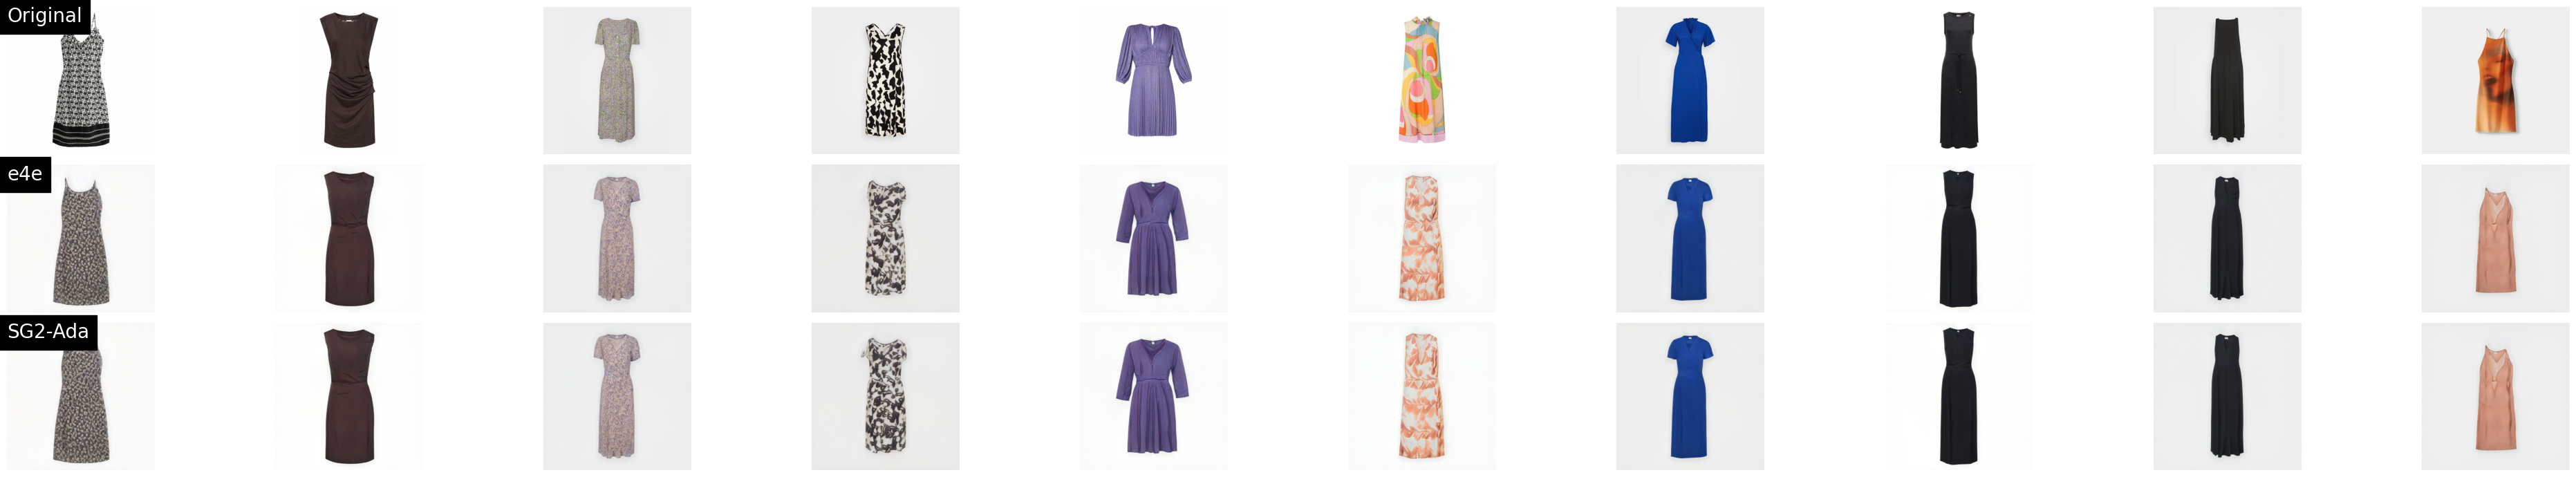

In [10]:
%matplotlib inline
num_samples = 10

test_images = glob("/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Zalando_Germany_Dataset/dresses/images/e4e_images/train/*jpg")
samples = np.random.choice(test_images,num_samples, replace=False)
fig, ax = plt.subplots(3, num_samples, figsize = (num_samples*4,7))

for i,sample in enumerate(samples):
    original, e4e_reconstruction, sg2_reconstruction = test_reconstruction(sample)
    
    ax[0,i].imshow(original)
    ax[1,i].imshow(e4e_reconstruction)
    ax[2,i].imshow(sg2_reconstruction)

    if i == 0:
            ax[0, i].text(0, 0, 'Original', color='white', backgroundcolor='black', fontsize=20, verticalalignment='top')
            ax[1, i].text(0, 0, 'e4e', color='white', backgroundcolor='black', fontsize=20, verticalalignment='top')
            ax[2, i].text(0, 0, 'SG2-Ada', color='white', backgroundcolor='black', fontsize=20, verticalalignment='top')

    ax[0,i].axis('off')
    ax[1,i].axis('off')
    ax[2,i].axis('off')

fig.tight_layout()
plt.show()